# Engineering Problem

## Imports

In [1]:
import logging
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from simrow_loader import SimrowLoader, ColumnType, SimrowDataset

Setup

In [2]:
# enable LaTeX rendering
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
    }
)

# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# configure logging
logging.basicConfig(level=logging.INFO)

Set random seeds

In [3]:
seed = 171  # np.random.randint(0, 1000)
np.random.seed(seed)
torch.manual_seed(seed)

print(f"Seed: {seed}")

Seed: 171


## Problem Data

In [4]:
simrow_loader = SimrowLoader("data.mat")

# Add columns to the dataset
simrow_loader.add_columns(
    ColumnType.Feature,
    "relativePos_headrestobserver",
    "relativeVel_headrestobserver",
    "relativeOri6d_headrestobserver",
    "relativeOmega_headrestobserver",
    "relativeOriAng_headrestobserver",
)


def squared_norm(data, field):
    return np.linalg.norm(data[field], axis=1) ** 2


simrow_loader.add_calculated_column(
    ColumnType.Feature,
    "relativePos_headrestobserver_squaredNorm",
    lambda data: squared_norm(data, "relativePos_headrestobserver"),
)
simrow_loader.add_calculated_column(
    ColumnType.Feature,
    "relativeVel_headrestobserver_squaredNorm",
    lambda data: squared_norm(data, "relativeVel_headrestobserver"),
)
simrow_loader.add_calculated_column(
    ColumnType.Feature,
    "relativeOriAng_headrestobserver_squaredNorm",
    lambda data: squared_norm(data, "relativeOriAng_headrestobserver"),
)
simrow_loader.add_calculated_column(
    ColumnType.Feature,
    "relativeOmega_headrestobserver_squaredNorm",
    lambda data: squared_norm(data, "relativeOmega_headrestobserver"),
)

simrow_loader.remove_columns(ColumnType.Feature, "relativeOriAng_headrestobserver")

simrow_loader.add_columns(
    ColumnType.Target,
    "force_headrestobserver",
)

print(
    "Feature columns\n", "\n".join(f"\t{col}" for col in simrow_loader.feature_columns)
)
print("Target columns\n", "\n".join(f"\t{col}" for col in simrow_loader.target_columns))

# Create train/val/test split
simrow_loader.create_split(train_ratio=0.9 * 0.7, val_ratio=0.9 * 0.3)  # 10% test set

unsc_feature_data, unsc_target_data, _ = simrow_loader.get_data(split="train")

scaler = StandardScaler()
scaler.fit(unsc_feature_data)

# include variance threshold
scaler.scale_ = np.where(scaler.var_ < 1e-10, 1.0, scaler.scale_)


def transform_data(feature_data: np.ndarray, target_data: np.ndarray):
    return scaler.transform(feature_data), target_data


simrow_loader.add_transform(transform_data)

# add noise to train and val data
noise = 0.05
simrow_loader.add_additive_noise("train", ColumnType.Feature, noise)
simrow_loader.add_additive_noise("val", ColumnType.Feature, noise)

# calculate distance to HF train data
train_feature_data, _, train_hf_flag = simrow_loader.get_data(split="train")
ball_tree = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(
    train_feature_data[train_hf_flag, :]
)
hf_train_distance, _ = ball_tree.kneighbors(train_feature_data)
hf_train_distance = hf_train_distance.squeeze()

val_feature_data, _, val_hf_flag = simrow_loader.get_data(split="val")
hf_val_distance, _ = ball_tree.kneighbors(val_feature_data)
hf_val_distance = hf_val_distance.squeeze()

test_feature_data, _, test_hf_flag = simrow_loader.get_data(split="test")
ball_tree = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(
    test_feature_data[test_hf_flag, :]
)
hf_test_distance, _ = ball_tree.kneighbors(test_feature_data)
hf_test_distance = hf_test_distance.squeeze()

# Get the processed data for training
train_dataset, val_dataset, test_dataset = simrow_loader.get_datasets()
print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

INFO:simrow_loader:Initializing SimrowLoader with data path: data.mat
INFO:simrow_loader:Loading data from data.mat
INFO:simrow_loader:Found 199 simulations with 401 samples each
INFO:simrow_loader:Loaded 8 columns with 86990 samples each
INFO:simrow_loader:Adding 5 columns of type feature
INFO:simrow_loader:Adding calculated column relativePos_headrestobserver_squaredNorm of type feature
INFO:simrow_loader:Adding calculated column relativeVel_headrestobserver_squaredNorm of type feature
INFO:simrow_loader:Adding calculated column relativeOriAng_headrestobserver_squaredNorm of type feature
INFO:simrow_loader:Adding calculated column relativeOmega_headrestobserver_squaredNorm of type feature
INFO:simrow_loader:Removing 1 columns of type feature
INFO:simrow_loader:Adding 1 columns of type target
INFO:simrow_loader:Aimed split ratios: train=0.630, val=0.270, test=0.100
INFO:simrow_loader:Initializing SimSplitter with 199 simulations, 401 samples per simulation, 86990 total samples
INFO:si

Feature columns
 	relativePos_headrestobserver
	relativeVel_headrestobserver
	relativeOri6d_headrestobserver
	relativeOmega_headrestobserver
	relativePos_headrestobserver_squaredNorm
	relativeVel_headrestobserver_squaredNorm
	relativeOriAng_headrestobserver_squaredNorm
	relativeOmega_headrestobserver_squaredNorm
Target columns
 	force_headrestobserver
Train dataset size: 54775
Val dataset size: 23475
Test dataset size: 8740


## Insight into the data

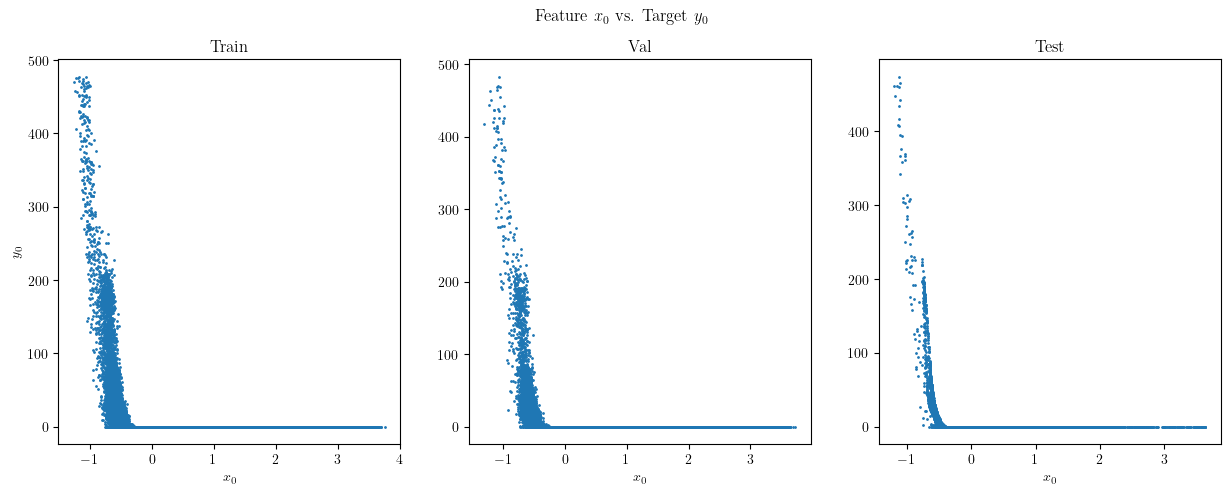

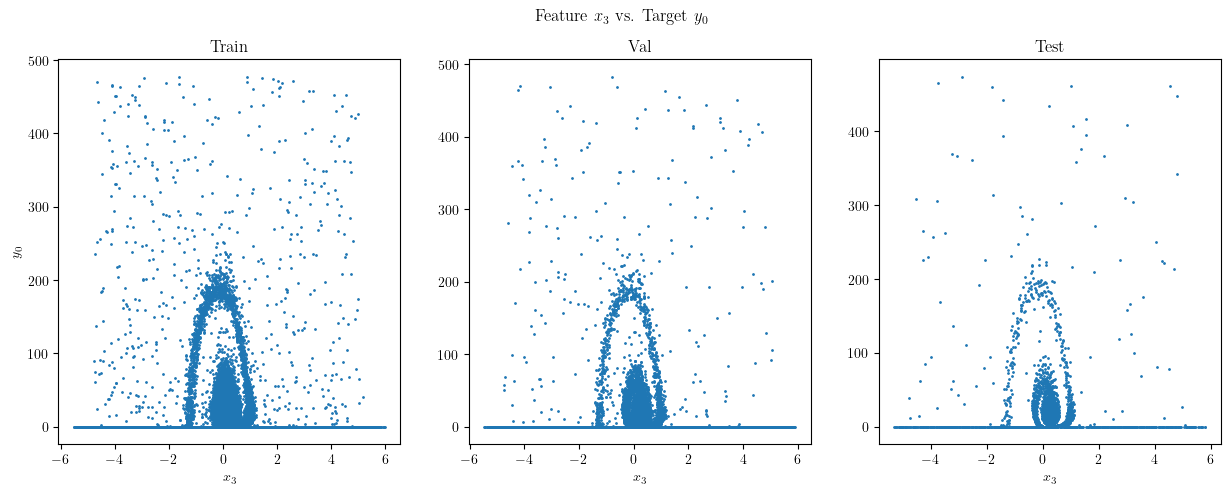

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, dataset in enumerate([train_dataset, val_dataset, test_dataset]):
    feature_data, target_data = dataset[:]
    ax[i].scatter(feature_data[:, 0], target_data[:, 0], s=1)
    ax[i].set_xlabel("$x_0$")
    ax[i].set_title(["Train", "Val", "Test"][i])
ax[0].set_ylabel("$y_0$")
fig.suptitle("Feature $x_0$ vs. Target $y_0$")
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, dataset in enumerate([train_dataset, val_dataset, test_dataset]):
    feature_data, target_data = dataset[:]
    ax[i].scatter(feature_data[:, 3], target_data[:, 0], s=1)
    ax[i].set_xlabel("$x_3$")
    ax[i].set_title(["Train", "Val", "Test"][i])
ax[0].set_ylabel("$y_0$")
fig.suptitle("Feature $x_3$ vs. Target $y_0$")
plt.show()

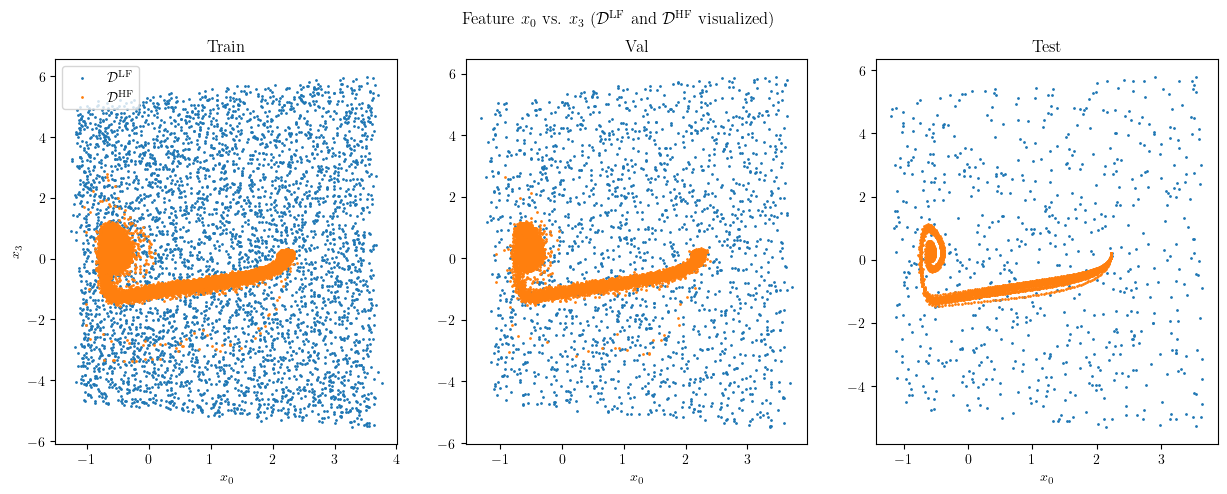

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, dataset in enumerate([train_dataset, val_dataset, test_dataset]):
    feature_data, target_data = dataset[:]
    ax[i].scatter(
        feature_data[~dataset.hf_flag, 0], feature_data[~dataset.hf_flag, 3], s=1
    )
    ax[i].scatter(
        feature_data[dataset.hf_flag, 0], feature_data[dataset.hf_flag, 3], s=1
    )
    ax[i].set_xlabel("$x_0$")
    ax[i].set_title(["Train", "Val", "Test"][i])
ax[0].set_ylabel("$x_3$")
ax[0].legend(["$\mathcal{D}^\mathrm{LF}$", "$\mathcal{D}^\mathrm{HF}$"])
fig.suptitle(
    "Feature $x_0$ vs. $x_3$ ($\mathcal{D}^\mathrm{LF}$ and $\mathcal{D}^\mathrm{HF}$ visualized)"
)
plt.show()

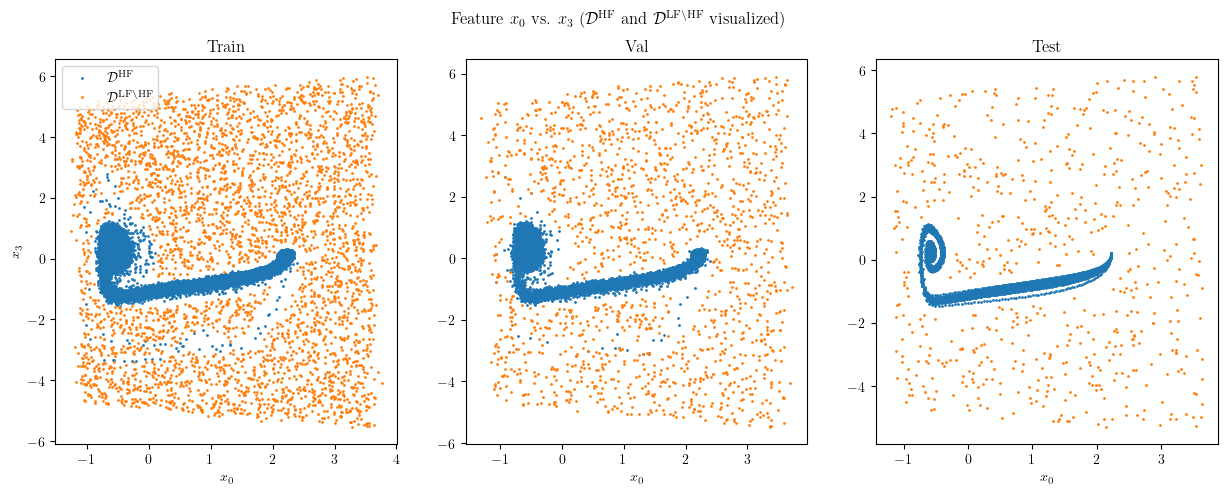

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, (distance, dataset) in enumerate(
    zip(
        [hf_train_distance, hf_val_distance, hf_test_distance],
        [train_dataset, val_dataset, test_dataset],
    )
):
    feature_data, target_data = dataset[:]
    ax[i].scatter(
        feature_data[dataset.hf_flag, 0], feature_data[dataset.hf_flag, 3], s=1
    )
    ax[i].scatter(feature_data[distance > 0.5, 0], feature_data[distance > 0.5, 3], s=1)
    # ax[i].scatter(feature_data[(distance <= 0.5) & (~dataset.hf_flag), 0], feature_data[(distance <= 0.5) & (~dataset.hf_flag), 3], s=1)
    ax[i].set_xlabel("$x_0$")
    ax[i].set_title(["Train", "Val", "Test"][i])
ax[0].legend(["$\mathcal{D}^\mathrm{HF}$", "$\mathcal{D}^\mathrm{LF\\backslash HF}$"])
ax[0].set_ylabel("$x_3$")
fig.suptitle(
    "Feature $x_0$ vs. $x_3$ ($\mathcal{D}^\mathrm{HF}$ and $\mathcal{D}^\mathrm{LF\\backslash HF}$ visualized)"
)
plt.show()

Calculate cardinalities of the sets

In [8]:
X, y, _ = simrow_loader.get_data(split="train")

trainlf_outside_hf = X[
    ((hf_train_distance.flatten() > 0.5) & (~train_hf_flag)), :
].shape[0]
trainLF = X[~train_hf_flag, :].shape[0]
trainHF = X[train_hf_flag, :].shape[0]

X, y, _ = simrow_loader.get_data(split="val")

vallf_outside_hf = X[((hf_val_distance.flatten() > 0.5) & (~val_hf_flag)), :].shape[0]
valLF = X[~val_hf_flag, :].shape[0]
valHF = X[val_hf_flag, :].shape[0]

X, y, _ = simrow_loader.get_data(split="test")

testlf_outside_hf = X[((hf_test_distance.flatten() > 0.5) & (~test_hf_flag)), :].shape[
    0
]
testLF = X[~test_hf_flag, :].shape[0]
testHF = X[test_hf_flag, :].shape[0]

print("HF:", trainHF + valHF + testHF)
print("LF:", trainLF + valLF + testLF)
print("LF outside HF:", trainlf_outside_hf + vallf_outside_hf + testlf_outside_hf)

HF: 79799
LF: 7191
LF outside HF: 5986


Create loader

In [9]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

## Train Baseline

In [10]:
baseline_model = torch.nn.Sequential(
    torch.nn.Linear(19, 15),
    torch.nn.Softplus(),
    torch.nn.Linear(15, 15),
    torch.nn.Softplus(),
    torch.nn.Linear(15, 5),
    torch.nn.Softplus(),
    torch.nn.Linear(5, 3),
)
baseline_model.to(device)

best_model = None
best_val_loss = float("inf")
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.005, weight_decay=1e-5)
for i in range(200):
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = baseline_model(X)
        loss = torch.nn.functional.mse_loss(y_pred, y)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        val_loss = 0
        for X, y in val_loader:
            break

        X, y = X.to(device), y.to(device)
        y_pred = baseline_model(X)
        val_loss = torch.nn.functional.mse_loss(y_pred, y)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(baseline_model)
        if (i + 1) % 20 == 0:
            print(f"Epoch {i+1}, val loss: {val_loss}, best val loss: {best_val_loss}")

Epoch 20, val loss: 30.299560546875, best val loss: 28.81545639038086
Epoch 40, val loss: 26.16778564453125, best val loss: 25.27962875366211
Epoch 60, val loss: 24.70914077758789, best val loss: 24.70914077758789
Epoch 80, val loss: 23.905208587646484, best val loss: 23.905208587646484
Epoch 100, val loss: 24.57341766357422, best val loss: 23.610916137695312
Epoch 120, val loss: 24.82425880432129, best val loss: 23.573810577392578
Epoch 140, val loss: 23.619237899780273, best val loss: 23.369548797607422
Epoch 160, val loss: 22.15719985961914, best val loss: 22.06779670715332
Epoch 180, val loss: 22.709705352783203, best val loss: 21.708208084106445
Epoch 200, val loss: 21.97890281677246, best val loss: 21.540075302124023


## Evaluate Baseline

In [11]:
X, y = test_loader.dataset[:]
X, y = torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(
    y, dtype=torch.float32
).to(device)

X_hf = X[test_hf_flag, :]
y_hf = y[test_hf_flag, :]

y_hf_pred = best_model(X_hf)

print(
    "HF test loss:",
    torch.nn.functional.mse_loss(y_hf_pred, y_hf).detach().cpu().numpy(),
)

X_lf = X[~test_hf_flag, :]
y_lf = y[~test_hf_flag, :]

y_lf_pred = best_model(X_lf)

print(
    "LF test loss:",
    torch.nn.functional.mse_loss(y_lf_pred, y_lf).detach().cpu().numpy(),
)

# lf inside hf is every lf that has less distance to hf than 0.5
X_lf_inside_hf = X[(hf_test_distance.flatten() < 0.5) & (~test_hf_flag), :]

y_lf_inside_hf = y[(hf_test_distance.flatten() < 0.5) & (~test_hf_flag), :]

y_lf_inside_hf_pred = best_model(X_lf_inside_hf)

print(
    "LF inside HF test loss:",
    torch.nn.functional.mse_loss(y_lf_inside_hf_pred, y_lf_inside_hf)
    .detach()
    .cpu()
    .numpy(),
)

# lf outside hf is every lf that has more distance to hf than 0.5
X_lf_outside_hf = X[(hf_test_distance.flatten() > 0.5) & (~test_hf_flag), :]

y_lf_outside_hf = y[(hf_test_distance.flatten() > 0.5) & (~test_hf_flag), :]

y_lf_outside_hf_pred = best_model(X_lf_outside_hf)

print(
    "LF outside HF test loss:",
    torch.nn.functional.mse_loss(y_lf_outside_hf_pred, y_lf_outside_hf)
    .detach()
    .cpu()
    .numpy(),
)

HF test loss: 8.453725
LF test loss: 84.27392
LF inside HF test loss: 579.7198
LF outside HF test loss: 27.520056


## Train Filter

In [12]:
# create new dataloader
X, y, _ = simrow_loader.get_data(split="train")
X_filter_train, y_filter_train = (
    X[
        (train_hf_flag) | ((hf_train_distance.flatten() > 0.5) & (~train_hf_flag)),
        :,
    ],
    y[
        (train_hf_flag) | ((hf_train_distance.flatten() > 0.5) & (~train_hf_flag)),
        :,
    ],
)
filter_train_loader = DataLoader(
    SimrowDataset(X_filter_train, y_filter_train, split="train"),
    batch_size=512,
    shuffle=True,
)

X, y, _ = simrow_loader.get_data(split="val")
X_filter_val, y_filter_val = (
    X[(val_hf_flag) | ((hf_val_distance.flatten() > 0.5) & (~val_hf_flag)), :],
    y[(val_hf_flag) | ((hf_val_distance.flatten() > 0.5) & (~val_hf_flag)), :],
)
filter_val_loader = DataLoader(
    SimrowDataset(X_filter_val, y_filter_val, split="val"),
    batch_size=len(X),
    shuffle=False,
)

filter_model = torch.nn.Sequential(
    torch.nn.Linear(19, 15),
    torch.nn.Softplus(),
    torch.nn.Linear(15, 15),
    torch.nn.Softplus(),
    torch.nn.Linear(15, 5),
    torch.nn.Softplus(),
    torch.nn.Linear(5, 3),
)
filter_model.to(device)

best_model = None
best_val_loss = float("inf")
optimizer = torch.optim.Adam(filter_model.parameters(), lr=0.005, weight_decay=1e-5)
for i in range(200):
    for X, y in filter_train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = filter_model(X)
        loss = torch.nn.functional.mse_loss(y_pred, y)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        val_loss = 0
        for X, y in filter_val_loader:
            break

        X, y = X.to(device), y.to(device)
        y_pred = filter_model(X)
        val_loss = torch.nn.functional.mse_loss(y_pred, y)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(filter_model)
        if (i + 1) % 20 == 0:
            print(f"Epoch {i+1}, val loss: {val_loss}, best val loss: {best_val_loss}")

Epoch 20, val loss: 25.692790985107422, best val loss: 25.692790985107422
Epoch 40, val loss: 27.087125778198242, best val loss: 24.445993423461914
Epoch 60, val loss: 24.272735595703125, best val loss: 23.676889419555664
Epoch 80, val loss: 23.328590393066406, best val loss: 23.328590393066406
Epoch 100, val loss: 23.845598220825195, best val loss: 23.199764251708984
Epoch 120, val loss: 22.499330520629883, best val loss: 22.499330520629883
Epoch 140, val loss: 25.549930572509766, best val loss: 21.854902267456055
Epoch 160, val loss: 21.235498428344727, best val loss: 21.235498428344727
Epoch 180, val loss: 22.834243774414062, best val loss: 20.911170959472656
Epoch 200, val loss: 20.982410430908203, best val loss: 20.202112197875977


## Evaluate Filter

In [13]:
X, y = test_loader.dataset[:]
X, y = torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(
    y, dtype=torch.float32
).to(device)

X_hf = X[test_hf_flag, :]
y_hf = y[test_hf_flag, :]

y_hf_pred = best_model(X_hf)

print(
    "HF test loss:",
    torch.nn.functional.mse_loss(y_hf_pred, y_hf).detach().cpu().numpy(),
)

X_lf = X[~test_hf_flag, :]
y_lf = y[~test_hf_flag, :]

y_lf_pred = best_model(X_lf)

print(
    "LF test loss:",
    torch.nn.functional.mse_loss(y_lf_pred, y_lf).detach().cpu().numpy(),
)

# lf inside hf is every lf that has less distance to hf than 0.5
X_lf_inside_hf = X[(hf_test_distance.flatten() < 0.5) & (~test_hf_flag), :]

y_lf_inside_hf = y[(hf_test_distance.flatten() < 0.5) & (~test_hf_flag), :]

y_lf_inside_hf_pred = best_model(X_lf_inside_hf)

print(
    "LF inside HF test loss:",
    torch.nn.functional.mse_loss(y_lf_inside_hf_pred, y_lf_inside_hf)
    .detach()
    .cpu()
    .numpy(),
)

# lf outside hf is every lf that has more distance to hf than 0.5
X_lf_outside_hf = X[(hf_test_distance.flatten() > 0.5) & (~test_hf_flag), :]

y_lf_outside_hf = y[(hf_test_distance.flatten() > 0.5) & (~test_hf_flag), :]

y_lf_outside_hf_pred = best_model(X_lf_outside_hf)

print(
    "LF outside HF test loss:",
    torch.nn.functional.mse_loss(y_lf_outside_hf_pred, y_lf_outside_hf)
    .detach()
    .cpu()
    .numpy(),
)

HF test loss: 8.8670845
LF test loss: 119.60349
LF inside HF test loss: 785.6653
LF outside HF test loss: 43.305378


## Train Pretrain

In [14]:
# create new dataloader
X, y, _ = simrow_loader.get_data(split="train")
X_pretrain_lf_train, y_pretrain_lf_train = X[~train_hf_flag], y[~train_hf_flag]
X_pretrain_hf_train, y_pretrain_hf_train = X[train_hf_flag], y[train_hf_flag]
pretrain_train_lf_loader = DataLoader(
    SimrowDataset(X_pretrain_lf_train, y_pretrain_lf_train, split="train"),
    batch_size=512,
    shuffle=True,
)
pretrain_train_hf_loader = DataLoader(
    SimrowDataset(X_pretrain_hf_train, y_pretrain_hf_train, split="train"),
    batch_size=512,
    shuffle=True,
)

X, y, _ = simrow_loader.get_data(split="val")
X_pretrain_lf_val, y_pretrain_lf_val = X[~val_hf_flag], y[~val_hf_flag]
X_pretrain_hf_val, y_pretrain_hf_val = X[val_hf_flag], y[val_hf_flag]
pretrain_val_lf_loader = DataLoader(
    SimrowDataset(X_pretrain_lf_val, y_pretrain_lf_val, split="val"),
    batch_size=len(X),
    shuffle=False,
)
pretrain_val_hf_loader = DataLoader(
    SimrowDataset(X_pretrain_hf_val, y_pretrain_hf_val, split="val"),
    batch_size=len(X),
    shuffle=False,
)


pretrain_model = torch.nn.Sequential(
    torch.nn.Linear(19, 15),
    torch.nn.Softplus(),
    torch.nn.Linear(15, 15),
    torch.nn.Softplus(),
    torch.nn.Linear(15, 5),
    torch.nn.Softplus(),
    torch.nn.Linear(5, 3),
)
pretrain_model.to(device)

best_model = None
best_val_loss = float("inf")
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=0.005, weight_decay=1e-5)
for i in range(400):
    for X, y in pretrain_train_lf_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = pretrain_model(X)
        loss = torch.nn.functional.mse_loss(y_pred, y)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        val_loss = 0
        for X, y in pretrain_val_lf_loader:
            break

        X, y = X.to(device), y.to(device)
        y_pred = pretrain_model(X)
        val_loss = torch.nn.functional.mse_loss(y_pred, y)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(pretrain_model)
        if (i + 1) % 20 == 0:
            print(f"Epoch {i+1}, val loss: {val_loss}, best val loss: {best_val_loss}")

print("Second stage:")
pretrain_model.load_state_dict(best_model.state_dict())
best_val_loss = float("inf")
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=0.005, weight_decay=1e-5)
for i in range(100):
    for X, y in pretrain_train_hf_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = pretrain_model(X)
        loss = torch.nn.functional.mse_loss(y_pred, y)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        val_loss = 0
        for X, y in pretrain_val_hf_loader:
            break

        X, y = X.to(device), y.to(device)
        y_pred = pretrain_model(X)
        val_loss = torch.nn.functional.mse_loss(y_pred, y)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(pretrain_model)
        if (i + 1) % 20 == 0:
            print(f"Epoch {i+1}, val loss: {val_loss}, best val loss: {best_val_loss}")

Epoch 20, val loss: 425.0762939453125, best val loss: 425.0762939453125
Epoch 40, val loss: 44.06106185913086, best val loss: 44.06106185913086
Epoch 60, val loss: 20.657079696655273, best val loss: 19.922285079956055
Epoch 80, val loss: 12.805601119995117, best val loss: 12.805601119995117
Epoch 100, val loss: 20.697105407714844, best val loss: 11.873805046081543
Epoch 120, val loss: 12.302164077758789, best val loss: 10.961777687072754
Epoch 140, val loss: 10.394152641296387, best val loss: 10.394152641296387
Epoch 160, val loss: 10.483880996704102, best val loss: 10.10080623626709
Epoch 180, val loss: 10.850808143615723, best val loss: 9.864356994628906
Epoch 200, val loss: 10.774480819702148, best val loss: 9.530205726623535
Epoch 220, val loss: 9.455792427062988, best val loss: 9.443235397338867
Epoch 240, val loss: 10.446866035461426, best val loss: 9.443235397338867
Epoch 260, val loss: 9.43283748626709, best val loss: 9.349546432495117
Epoch 280, val loss: 9.535165786743164, be

## Evaluate Pretrain

In [15]:
X, y = test_loader.dataset[:]
X, y = torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(
    y, dtype=torch.float32
).to(device)

X_hf = X[test_hf_flag, :]
y_hf = y[test_hf_flag, :]

y_hf_pred = best_model(X_hf)

print(
    "HF test loss:",
    torch.nn.functional.mse_loss(y_hf_pred, y_hf).detach().cpu().numpy(),
)

X_lf = X[~test_hf_flag, :]
y_lf = y[~test_hf_flag, :]

y_lf_pred = best_model(X_lf)

print(
    "LF test loss:",
    torch.nn.functional.mse_loss(y_lf_pred, y_lf).detach().cpu().numpy(),
)

# lf inside hf is every lf that has less distance to hf than 0.5
X_lf_inside_hf = X[(hf_test_distance.flatten() < 0.5) & (~test_hf_flag), :]

y_lf_inside_hf = y[(hf_test_distance.flatten() < 0.5) & (~test_hf_flag), :]

y_lf_inside_hf_pred = best_model(X_lf_inside_hf)

print(
    "LF inside HF test loss:",
    torch.nn.functional.mse_loss(y_lf_inside_hf_pred, y_lf_inside_hf)
    .detach()
    .cpu()
    .numpy(),
)

# lf outside hf is every lf that has more distance to hf than 0.5
X_lf_outside_hf = X[(hf_test_distance.flatten() > 0.5) & (~test_hf_flag), :]

y_lf_outside_hf = y[(hf_test_distance.flatten() > 0.5) & (~test_hf_flag), :]

y_lf_outside_hf_pred = best_model(X_lf_outside_hf)

print(
    "LF outside HF test loss:",
    torch.nn.functional.mse_loss(y_lf_outside_hf_pred, y_lf_outside_hf)
    .detach()
    .cpu()
    .numpy(),
)

HF test loss: 7.0697613
LF test loss: 994.8803
LF inside HF test loss: 1338.359
LF outside HF test loss: 955.5345


## Train Decidernet

In [16]:
# decidernet
X, y, _ = simrow_loader.get_data(split="train")
X_decider_train, y_decider_train = X, train_hf_flag.astype(np.float32).reshape(-1, 1)
decider_train_loader = DataLoader(
    SimrowDataset(X_decider_train, y_decider_train, split="train"),
    batch_size=512,
    shuffle=True,
)

X, y, _ = simrow_loader.get_data(split="val")
X_decider_val, y_decider_val = X, val_hf_flag.astype(np.float32).reshape(-1, 1)
decider_val_loader = DataLoader(
    SimrowDataset(X_decider_val, y_decider_val, split="val"),
    batch_size=len(X),
    shuffle=False,
)


decider_model = torch.nn.Sequential(
    torch.nn.Linear(19, 10),
    torch.nn.Softplus(),
    torch.nn.Linear(10, 5),
    torch.nn.Softplus(),
    torch.nn.Linear(5, 1),
    torch.nn.Sigmoid(),
)
best_decider_model = None
best_val_loss = float("inf")
decider_model.to(device)
decider_optimizer = torch.optim.Adam(
    decider_model.parameters(), lr=0.005, weight_decay=1e-5
)
for i in range(50):
    for X, y in decider_train_loader:
        X, y = X.to(device), y.to(device)
        decider_optimizer.zero_grad()
        y_pred = decider_model(X)
        loss = torch.nn.functional.mse_loss(y_pred, y)
        loss.backward()
        decider_optimizer.step()
    with torch.no_grad():
        val_loss = 0
        for X, y in decider_val_loader:
            break

        X, y = X.to(device), y.to(device)
        y_pred = decider_model(X)
        val_loss = torch.nn.functional.mse_loss(y_pred, y)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_decider_model = deepcopy(decider_model)
        if (i + 1) % 10 == 0:
            print(f"Epoch {i+1}, val loss: {val_loss}, best val loss: {best_val_loss}")

X, y, _ = simrow_loader.get_data(split="train")
X_predictor_train, y_predictor_train = (
    np.concatenate([X, train_hf_flag.astype(np.float32).reshape(-1, 1)], axis=1),
    y,
)
predictor_train_loader = DataLoader(
    SimrowDataset(X_predictor_train, y_predictor_train, split="train"),
    batch_size=512,
    shuffle=True,
)

X, y, _ = simrow_loader.get_data(split="val")
X_predictor_val, y_predictor_val = (
    np.concatenate([X, val_hf_flag.astype(np.float32).reshape(-1, 1)], axis=1),
    y,
)
predictor_val_loader = DataLoader(
    SimrowDataset(X_predictor_val, y_predictor_val, split="val"),
    batch_size=len(X),
    shuffle=False,
)

predictor_model = torch.nn.Sequential(
    torch.nn.Linear(20, 15),
    torch.nn.Softplus(),
    torch.nn.Linear(15, 15),
    torch.nn.Softplus(),
    torch.nn.Linear(15, 10),
    torch.nn.Softplus(),
    torch.nn.Linear(10, 3),
)
best_predictor_model = None
best_val_loss = float("inf")
predictor_model.to(device)
predictor_optimizer = torch.optim.Adam(
    predictor_model.parameters(), lr=0.005, weight_decay=1e-5
)
for i in range(200):
    for X, y in predictor_train_loader:
        X, y = X.to(device), y.to(device)
        predictor_optimizer.zero_grad()
        y_pred = predictor_model(X)
        loss = torch.nn.functional.mse_loss(y_pred, y)
        loss.backward()
        predictor_optimizer.step()
    with torch.no_grad():
        val_loss = 0
        for X, y in predictor_val_loader:
            break

        X, y = X.to(device), y.to(device)
        y_pred = predictor_model(X)
        val_loss = torch.nn.functional.mse_loss(y_pred, y)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_predictor_model = deepcopy(predictor_model)
        if (i + 1) % 20 == 0:
            print(f"Epoch {i+1}, val loss: {val_loss}, best val loss: {best_val_loss}")

Epoch 10, val loss: 0.015051539987325668, best val loss: 0.014802156016230583
Epoch 20, val loss: 0.014222001656889915, best val loss: 0.014222001656889915
Epoch 30, val loss: 0.014202656224370003, best val loss: 0.014101775363087654
Epoch 40, val loss: 0.013021064922213554, best val loss: 0.013021064922213554
Epoch 50, val loss: 0.012871448881924152, best val loss: 0.01248554140329361
Epoch 20, val loss: 20.34670066833496, best val loss: 20.34670066833496
Epoch 40, val loss: 22.34104347229004, best val loss: 19.990365982055664
Epoch 60, val loss: 19.600605010986328, best val loss: 19.15494155883789
Epoch 80, val loss: 18.459692001342773, best val loss: 18.459692001342773
Epoch 100, val loss: 17.84785270690918, best val loss: 17.84785270690918
Epoch 120, val loss: 18.684797286987305, best val loss: 17.63654899597168
Epoch 140, val loss: 19.598594665527344, best val loss: 17.39729881286621
Epoch 160, val loss: 18.160781860351562, best val loss: 17.14402198791504
Epoch 180, val loss: 17.

## Evaluate Decidernet

In [17]:
def sigmoid(x, steepness=1e5, threshold=0.4):
    tmp = (x - threshold) * steepness
    tmp = torch.clamp(tmp, -50, 50)
    return 1 / (1 + torch.exp(-tmp))


X, y = test_loader.dataset[:]
X, y = torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(
    y, dtype=torch.float32
).to(device)

fid_pred = best_decider_model(X)
fid_pred = sigmoid(fid_pred)

X_hf = X[test_hf_flag, :]
y_hf = y[test_hf_flag, :]

X_hf = torch.concatenate([X_hf, fid_pred[test_hf_flag]], axis=1)

y_hf_pred = best_predictor_model(X_hf)

print(
    "HF test loss:",
    torch.nn.functional.mse_loss(y_hf_pred, y_hf).detach().cpu().numpy(),
)

X_lf = X[~test_hf_flag, :]
y_lf = y[~test_hf_flag, :]

X_lf = torch.concatenate([X_lf, fid_pred[~test_hf_flag]], axis=1)

y_lf_pred = best_predictor_model(X_lf)

print(
    "LF test loss:",
    torch.nn.functional.mse_loss(y_lf_pred, y_lf).detach().cpu().numpy(),
)

# lf inside hf is every lf that has less distance to hf than 0.5
indices = (hf_test_distance.flatten() < 0.5) & (~test_hf_flag)
X_lf_inside_hf = X[indices, :]

y_lf_inside_hf = y[indices, :]

X_lf_inside_hf = torch.concatenate([X_lf_inside_hf, fid_pred[indices]], axis=1)

y_lf_inside_hf_pred = best_predictor_model(X_lf_inside_hf)

print(
    "LF inside HF test loss:",
    torch.nn.functional.mse_loss(y_lf_inside_hf_pred, y_lf_inside_hf)
    .detach()
    .cpu()
    .numpy(),
)

# lf outside hf is every lf that has more distance to hf than 0.5
indices = (hf_test_distance.flatten() > 0.5) & (~test_hf_flag)
X_lf_outside_hf = X[indices, :]

y_lf_outside_hf = y[indices, :]

X_lf_outside_hf = torch.concatenate([X_lf_outside_hf, fid_pred[indices]], axis=1)

y_lf_outside_hf_pred = best_predictor_model(X_lf_outside_hf)

print(
    "LF outside HF test loss:",
    torch.nn.functional.mse_loss(y_lf_outside_hf_pred, y_lf_outside_hf)
    .detach()
    .cpu()
    .numpy(),
)

HF test loss: 6.020791
LF test loss: 309.09515
LF inside HF test loss: 1429.6676
LF outside HF test loss: 180.73235
